In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyedflib py-ecg-detectors adapt

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import numpy as np
from ecgdetectors import Detectors
import time
import pyedflib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from adapt.instance_based import KMM, NearestNeighborsWeighting 

In [ ]:
### rri_hrv를 돌리고 hrv 데이터를 만든 후 입니다 ###

In [4]:
### 여러가지 시도하면서 만들게 된 dataset 디렉토리 ###

# 경로

path = '/content/drive/MyDrive/cs/mission_1/'
csvpath = path + 'to_csv/'
txtpath = path + 'input/'
excludedpath = csvpath + 'excluded_hrv/'

# 사람 list

patientlist = []
for i in os.listdir(txtpath):
    patientlist.append(i)

# dataset 생성

dataset = {}
for name in patientlist:
    dataset[name] = {}
    for i in os.listdir(csvpath):
        if "HRV.csv" in i and name in i:
            dataset[name]['hrv'] = pd.read_csv(csvpath + i)

for name in patientlist:
    for i in os.listdir(excludedpath):
        if f"HRV.csv" in i and name in i:
            dataset[name]['excluded_hrv'] = pd.read_csv(excludedpath + i).iloc[:,1:]

for name in patientlist:
    dataset[name]['txt'] = {}
    dataset[name]['txt']['data'] = pd.read_csv(glob.glob(txtpath + name + '/*.txt')[0], sep = "\t", header = 12)

features = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni',
        'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'total_power',
        'vlf', 'sampen', 'csi', 'cvi', 'Modified_csi', 'sd1', 'sd2', 'ratio_sd2_sd1', 'triangular_index', 'tinn', 'PSI', 'MSI','remark']

from scipy.signal.fir_filter_design import kaiser_atten

signal_path = '/content/drive/MyDrive/cs/mission_1/input'
for i in os.listdir(signal_path):
    dataset[i]['edf']={}
    for j in os.listdir(os.path.join(signal_path,i)):
        if '.edf' in j:
            f = pyedflib.EdfReader(os.path.join(signal_path,i,j))
            list_signal = f.getSignalLabels()
            ekg_index = list_signal.index('EKG')
            dataset[i]['edf']['ecg'] = f.readSignal(ekg_index)
            dataset[i]['edf']['samplingrate'] = int(len(dataset[i]['edf']['ecg'])/f.getFileDuration())
            edf_start_obj = f.getStartdatetime()
            dataset[i]['edf']['startobj'] = edf_start_obj
            edf_start_unix = time.mktime(edf_start_obj.timetuple())
            dataset[i]['edf']['startunix'] = edf_start_unix
            dataset[i]['edf']['duration'] = f.getFileDuration()
            # print( i,str(f.getFileDuration()/3600),'시간')
            f.close()
        elif '.txt' in j:
            f = open(os.path.join(signal_path,i,j), 'r')
            k = 0

            dataset[i]['index'] = []
            
            while True:
                line = f.readline()
                if not line:
                    break
                k += 1

                if k >= 17:
                    items = line.split("\t")
                    ss_end_obj = datetime.datetime.strptime(items[2], '%Y-%m-%dT%H:%M:%S.000000')
                    ss_end_unix = time.mktime(ss_end_obj.timetuple())

                    dataset[i]['index'].append(ss_end_unix - dataset[i]['edf']['startunix'])
                    
                    if k == 17:
                        dataset[i]['txt']['startobj'] = ss_end_obj
                        dataset[i]['txt']['startunix'] = ss_end_unix
                    dataset[i]['txt']['endobj'] = ss_end_obj
                    dataset[i]['txt']['endunix'] = ss_end_unix                  


            f.close()
            
# a.txt의 시간범위만큼 ecg 추출

for i in patientlist:
    ecgstart = int(dataset[i]['txt']['startunix']-dataset[i]['edf']['startunix'])*200
    ecgend = int(dataset[i]['txt']['endunix']-dataset[i]['edf']['startunix']+30.0)*200
    # print(i,str((ecgend - ecgstart)/3600/200),'시간')
    dataset[i]['rangeecg'] = dataset[i]['edf']['ecg'][ecgstart:ecgend]


# Peak detection

from ecgdetectors import Detectors

for i in patientlist:
    ecg = dataset[i]['rangeecg']
    fs = dataset[i]['edf']['samplingrate']

    detectors = Detectors(fs)
    r_peaks_a = detectors.two_average_detector(ecg)

    dataset[i]['rangepeaks'] = r_peaks_a

# R_mask

for name in patientlist:
    ecg = dataset[name]['rangeecg']
    rpeaks = np.array(dataset[name]['rangepeaks'])
    fs = dataset[name]['edf']['samplingrate']
    R_mask = np.zeros(len(ecg), int)
    R_mask[rpeaks] = 1
    dataset[name]['R_mask'] = R_mask

                        

In [ ]:
### 데이터셋 구성 ###
'''
dataset[name]['hrv']
dataset[name]['excluded_hrv']
dataset[name]['rangeecg']
dataset[name]['rangepeaks']

dataset[name]['edf']['ecg']
dataset[name]['edf']['duration']
dataset[name]['edf']['samplingrate']
dataset[name]['edf']['startobj']
dataset[name]['edf']['startunix']

dataset[name]['txt']['data']
dataset[name]['txt']['startobj']
dataset[name]['txt']['startunix']
dataset[name]['txt']['endobj']
dataset[name]['txt']['endunix']


dataset[name]['index']

###################################
dataset[name]['stftspectrogram']
dataset[name]['stftSS']
'''

In [5]:
dataset['kgk']['hrv'].columns

Index(['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf', 'sampen', 'csi', 'cvi', 'Modified_csi', 'sd1',
       'sd2', 'ratio_sd2_sd1', 'triangular_index', 'tinn', 'SRD', 'PSI', 'MSI',
       'SS', 'nec', 'etc', 'remark', 'subject', 'patient_id', 'ss_end_obj'],
      dtype='object')

In [6]:
## 기본 feature 선택 ##

features = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni',
        'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'total_power',
        'vlf', 'sampen', 'csi', 'cvi', 'Modified_csi', 'sd1', 'sd2', 'ratio_sd2_sd1', 'triangular_index', 'tinn', 'PSI', 'MSI','remark']

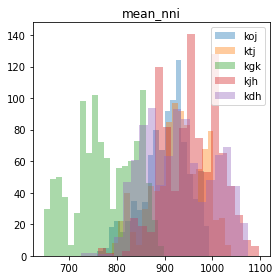

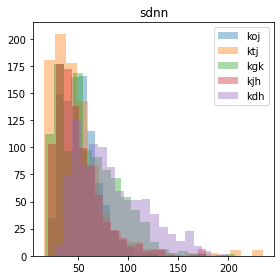

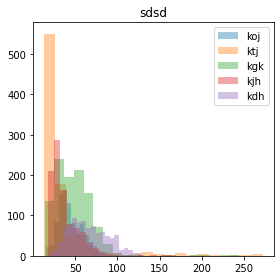

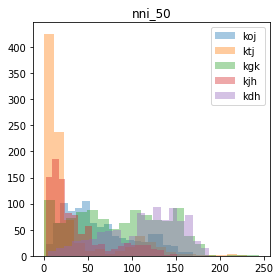

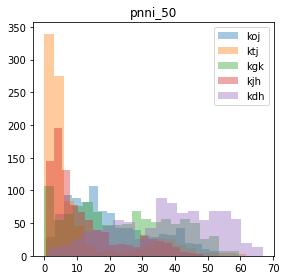

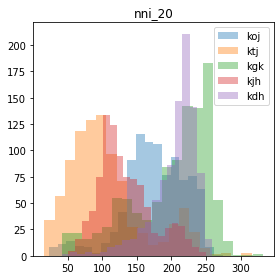

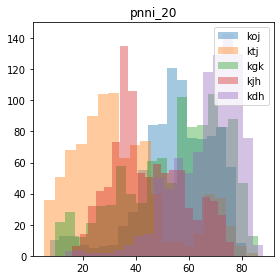

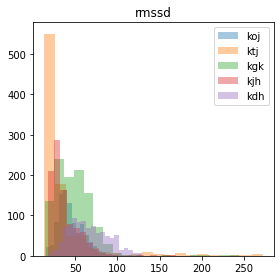

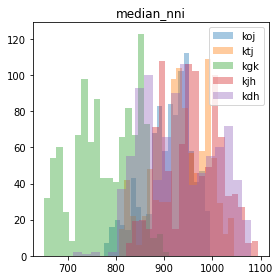

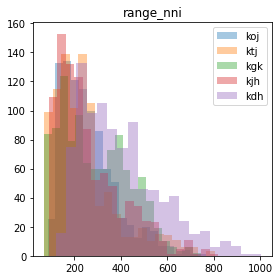

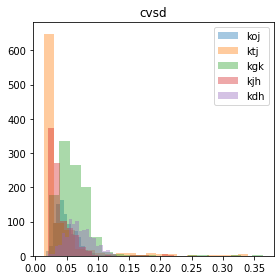

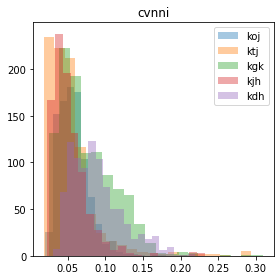

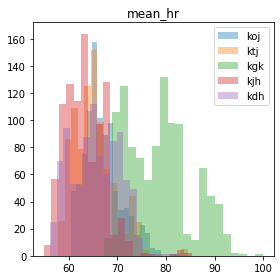

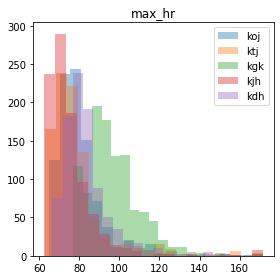

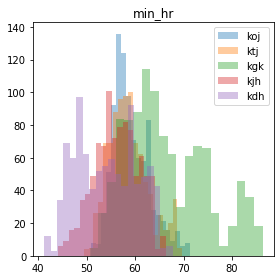

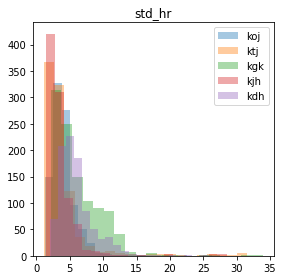

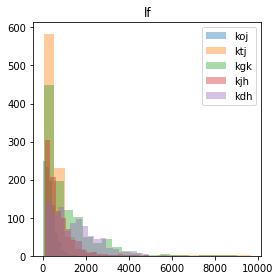

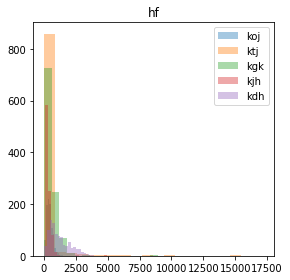

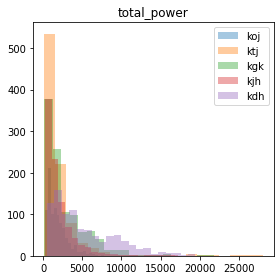

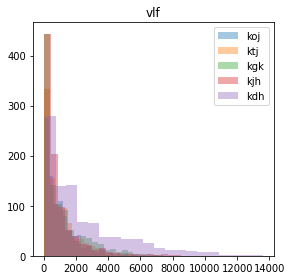

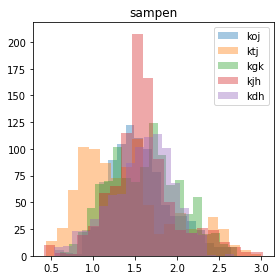

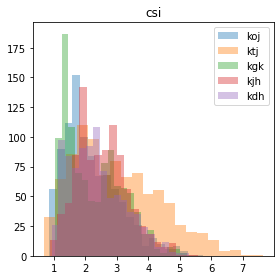

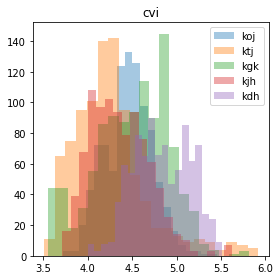

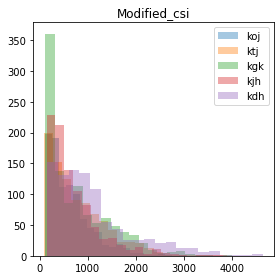

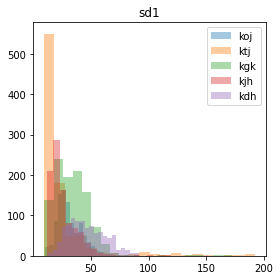

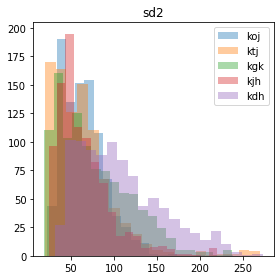

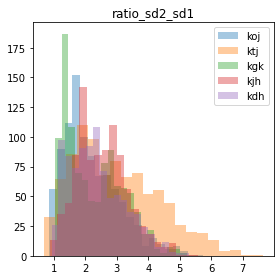

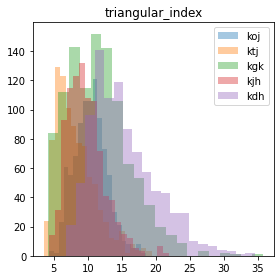

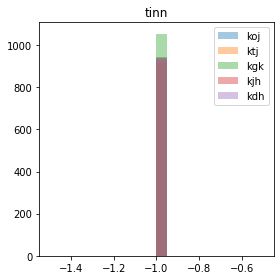

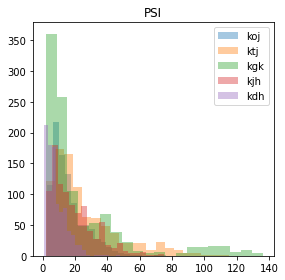

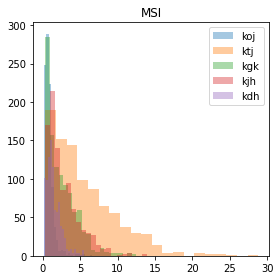

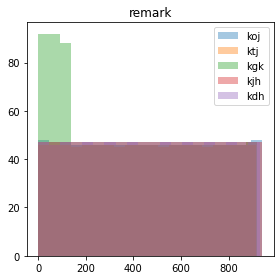

In [17]:
## 학습에 이용되는 feature 분포
for i in features:
    bins = 20
    
    plt.title(i)
    for name in patientlist:
        plt.hist(dataset[name]['hrv'][i], bins, alpha = 0.4, label = name, color = None)
    plt.legend(loc='upper right')

    plt.show()

### 다른 사람들에 비해 'kgk'이 편향이 있다.
### 편향이 있는 feature은 'kgk' 기준 'mean_nni','median_nni','mean_hr','max_hr','min_hr' ###

In [ ]:
Xs = dataset['kgk']['excluded_hrv'][features]
ys = dataset['kgk']['excluded_hrv']['SS']

Xt = dataset['kgk']['hrv'][features]
yt = dataset['kgk']['hrv']['SS']

In [ ]:
Xs.shape, ys.shape, Xt.shape, yt.shape

((3728, 32), (3728,), (1055, 32), (1055,))

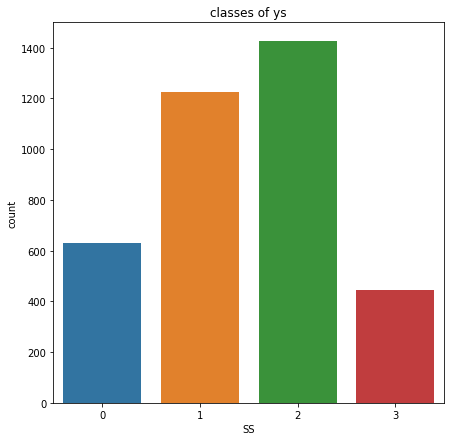

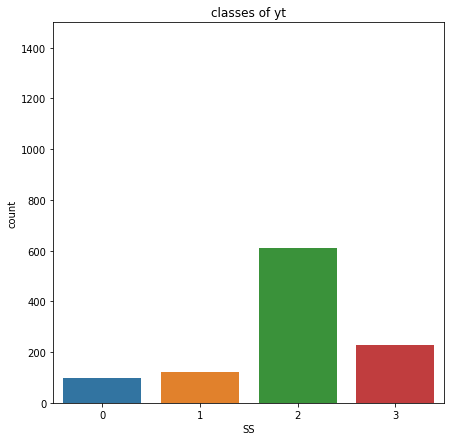

In [ ]:
def label_plot(n,data,title,ylim):
  plt.figure(figsize=(n, n))
  sns.countplot(data)
  plt.ylim(ylim)
  plt.title(title)
  return plt.show()

label_plot(7,ys,"classes of ys",(0.0,1500.0))
label_plot(7,yt,"classes of yt",(0.0,1500.0))

In [ ]:
# RandomizedSearchCV parameter
param_knn = {
    'p' : [1,2],
    'n_neighbors' : np.arange(1,5,1),
    'weights' : ['uniform', 'distance'] ,
}

In [ ]:
randomknn = RandomizedSearchCV(
KNeighborsClassifier(),                        
param_distributions=param_knn,
n_iter=80,                  
cv=5,                       
scoring='accuracy',
verbose=1,                  
n_jobs=-1)

In [ ]:
scaler = MinMaxScaler()

scaled_Xs = scaler.fit_transform(Xs)

scaled_Xt = scaler.transform(Xt)

In [ ]:
randomknn.fit(scaled_Xs, ys)
print(randomknn.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'weights': 'uniform', 'p': 1, 'n_neighbors': 3}


Accuracy of K-NN classifier on training set: 86.61
Accuracy of K-NN classifier on test set: 25.21
K-NN classifier - Test set


Predicted,W,N1,N2,R
Actual,,,,
W,52,26,19,2
N1,71,32,8,9
N2,275,105,163,67
R,104,80,23,19


              precision    recall  f1-score   support

           0       0.10      0.53      0.17        99
           1       0.13      0.27      0.18       120
           2       0.77      0.27      0.40       610
           3       0.20      0.08      0.12       226

    accuracy                           0.25      1055
   macro avg       0.30      0.29      0.22      1055
weighted avg       0.51      0.25      0.29      1055

W == 0 : 99, N1 == 1 : 120, N2 == 2 : 610, R == 3 : 226


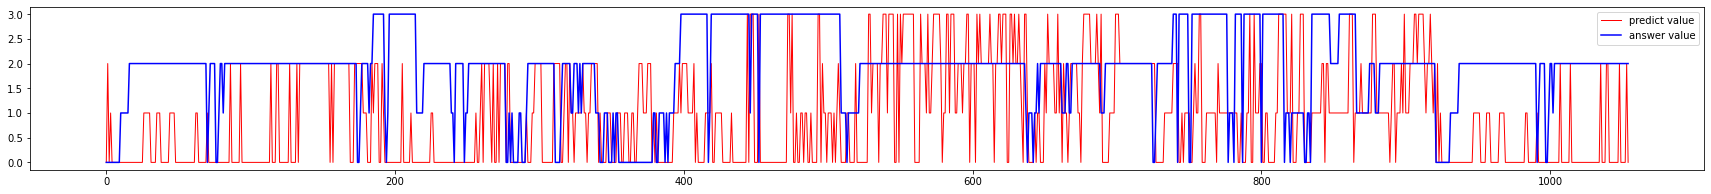

In [ ]:
knn = KNeighborsClassifier(p=1, n_neighbors=3)
knn.fit(scaled_Xs, ys)
print(f"Accuracy of K-NN classifier on training set: {knn.score(scaled_Xs, ys)*100:.2f}")
print(f"Accuracy of K-NN classifier on test set: {knn.score(scaled_Xt, yt)*100:.2f}")

print(f"K-NN classifier - Test set")
pred = knn.predict(scaled_Xt)
cm = confusion_matrix(yt, pred)
cm = pd.DataFrame(cm, index=["W","N1", "N2", "R"], columns=["W","N1", "N2", "R"])
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)
print(classification_report(yt, pred))   

df = dataset['kgk']['hrv']

print(f"W == 0 : {len(df[df['SS']==0])}, N1 == 1 : {len(df[df['SS']==1])}, N2 == 2 : {len(df[df['SS']==2])}, R == 3 : {len(df[df['SS']==3])}") 
plt.figure(figsize=(30, 3))
plt.plot(pred, c='r', label = 'predict value',linewidth = 1)
plt.plot(yt, c='b', label='answer value',linewidth = 1.5)
plt.legend()
plt.show()
print('==============================================================================')

In [ ]:
# adpat 모델 KMM

adapt_model1 = KMM(
    estimator=knn,
    # estimator=KNeighborsClassifier(p=1, n_neighbors=1),
    Xt=Xt,
    kernel="rbf",  # Gaussian kernel
    gamma=1.,     # Bandwidth of the kernel
    verbose=0,
    random_state=0
)

# Fit the model.
adapt_model1.fit(Xs, ys);

# Get the score on target data
adapt_model1.score(Xt, yt)


### 0.2521  ->   0.3820     accuracy 13퍼 증가
### 성능 개선을 위해 전처리와 더 적합한 분류기 모델과 더 좋은 adapt 모델을 찾고 모델 하이퍼 파라미터 튜닝이 필요하다고 생각함

0.3819905213270142

Predicted,W,N1,N2,R
Actual,,,,
W,24,28,32,15
N1,30,40,19,31
N2,180,104,276,50
R,37,75,51,63


              precision    recall  f1-score   support

           0       0.09      0.24      0.13        99
           1       0.16      0.33      0.22       120
           2       0.73      0.45      0.56       610
           3       0.40      0.28      0.33       226

    accuracy                           0.38      1055
   macro avg       0.34      0.33      0.31      1055
weighted avg       0.53      0.38      0.43      1055

W == 0 : 99, N1 == 1 : 120, N2 == 2 : 610, R == 3 : 226


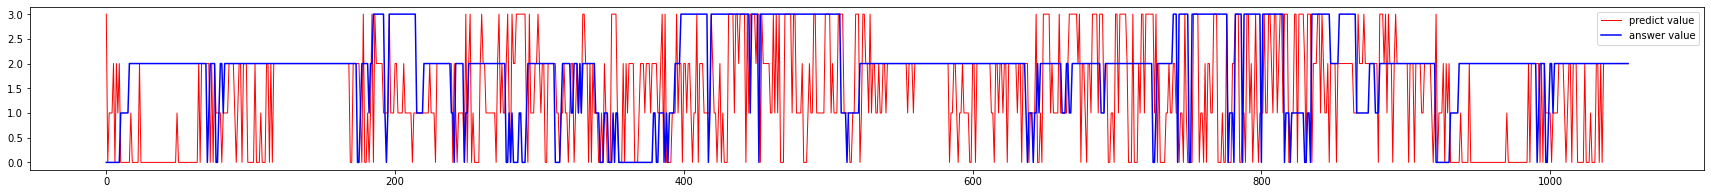

In [ ]:
pred = adapt_model1.predict(Xt)
cm = confusion_matrix(yt, pred)
cm = pd.DataFrame(cm, index=["W","N1", "N2", "R"], columns=["W","N1", "N2", "R"])
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)
print(classification_report(yt, pred))   

df = dataset['kgk']['hrv']

print(f"W == 0 : {len(df[df['SS']==0])}, N1 == 1 : {len(df[df['SS']==1])}, N2 == 2 : {len(df[df['SS']==2])}, R == 3 : {len(df[df['SS']==3])}") 
plt.figure(figsize=(30, 3))
plt.plot(pred, c='r', label = 'predict value',linewidth = 1)
plt.plot(yt, c='b', label='answer value',linewidth = 1.5)
plt.legend()
plt.show()
print('==============================================================================')

In [ ]:
# adpat 모델 NearestNeighborsWeighting 

adapt_model2 = NearestNeighborsWeighting (
    estimator=knn,
    # estimator=KNeighborsClassifier(p=1, n_neighbors=1),
    n_neighbors = 1,
    p = 1,
    Xt=Xt,
    verbose=0,
    random_state=0
)

# Fit the model.
adapt_model2.fit(Xs, ys);

# Get the score on target data
adapt_model2.score(Xt, yt)


### 0.2521  ->   0.3886     accuracy 13.6퍼 증가
### 성능 개선을 위해 전처리와 더 적합한 분류기 모델과 더 좋은 adapt 모델을 찾고 모델 하이퍼 파라미터 튜닝이 필요하다고 생각함

0.3886255924170616

Predicted,W,N1,N2,R
Actual,,,,
W,18,31,28,22
N1,27,46,17,30
N2,163,118,268,61
R,27,79,42,78


              precision    recall  f1-score   support

           0       0.08      0.18      0.11        99
           1       0.17      0.38      0.23       120
           2       0.75      0.44      0.56       610
           3       0.41      0.35      0.37       226

    accuracy                           0.39      1055
   macro avg       0.35      0.34      0.32      1055
weighted avg       0.55      0.39      0.44      1055

W == 0 : 99, N1 == 1 : 120, N2 == 2 : 610, R == 3 : 226


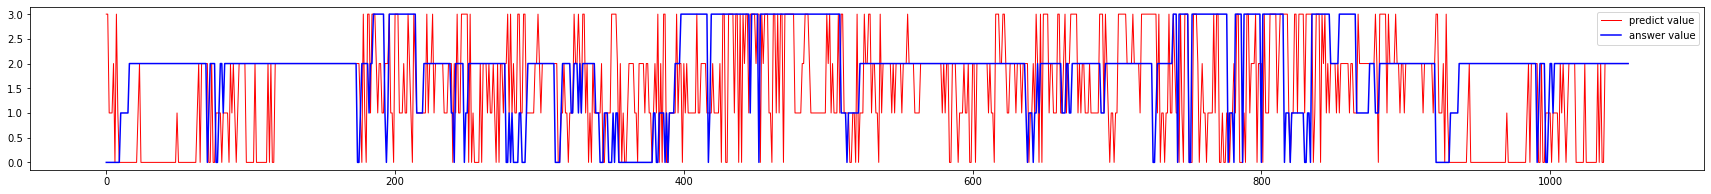

In [ ]:
pred = adapt_model2.predict(Xt)
cm = confusion_matrix(yt, pred)
cm = pd.DataFrame(cm, index=["W","N1", "N2", "R"], columns=["W","N1", "N2", "R"])
cm.index.name = "Actual"
cm.columns.name = "Predicted"
display(cm)
print(classification_report(yt, pred))   

df = dataset['kgk']['hrv']

print(f"W == 0 : {len(df[df['SS']==0])}, N1 == 1 : {len(df[df['SS']==1])}, N2 == 2 : {len(df[df['SS']==2])}, R == 3 : {len(df[df['SS']==3])}") 
plt.figure(figsize=(30, 3))
plt.plot(pred, c='r', label = 'predict value',linewidth = 1)
plt.plot(yt, c='b', label='answer value',linewidth = 1.5)
plt.legend()
plt.show()
print('==============================================================================')

In [ ]:
### 시간 관계상 써먹지는 못하였음 ###

import pylab 
from scipy import signal

#########
def figure_to_array(fig):
    """
    plt.figure를 RGBA로 변환(layer가 4개)
    shape: height, width, layer
    """
    fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)
#########

## Spectrogram type 1
for name in patientlist:

    z = dataset[name]['edf']['ecg']
    Fs = dataset[name]['edf']['samplingrate']

    index = dataset[name]['index']

    dataset[name]['stftspectrogram'] = []
    dataset[name]['subtractframe'] = [0]

    for start in index:

        end = start + 30*Fs

        if end > len(z):
            print(f'end가 z의 길이보다 큽니다.  {name} start : {start}, end : {end}')
            dataset[name]['subtractframe'] = [1, start, end]
            break
        else:
            zframe = z[start:end]

            f, tt, Sxx = signal.spectrogram(zframe, Fs)

########## 해결이 필요한 부분 - 이미지화 -> np.array
            fig = plt.figure()
            plt.pcolormesh(tt, f, Sxx, shading='gouraud')
            plt.close()
            f_arr = figure_to_array(fig)
##########


            dataset[name]['stftspectrogram'].append(f_arr)


    if dataset[name]['subtractframe'][0] == 1:
        dataset[name]['stftSS'] = dataset[name]['hrv'][['SS']][:-1]
    else:
        dataset[name]['stftSS'] = dataset[name]['hrv'][['SS']]